### Loading the libraries

In [33]:
#for importing the data
from pathlib import Path
from numpy import loadtxt

# for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import IsolationForest

# for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

In [2]:
pd.set_option("display.max_columns", None)

In [49]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

### Loading the data from Kaggle

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 183MB/s]


In [6]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [8]:
# LOAD THE CSV dataset into a pandas dataframe
df = pd.read_csv('AB_NYC_2019.csv')

### Data Cleaning and Transformation

In [9]:
print('number of rows in the dataset:', len(df))
df.head()

number of rows in the dataset: 48895


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [10]:
### Statistical indicators for each column
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [12]:
## Check presence of rows with null values
df.isna().any()

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [13]:
# Replace all NaN values in 'reviews_per_month' with 0
df.fillna({'reviews_per_month':0}, inplace=True)

In [14]:
# Remove non-interesting for our target: name, host_name, host_id, last_review
df=df.drop(['name','host_name',	'last_review', 'host_id','id'], axis=1)

In [15]:
df.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [16]:
# ONE-HOT ENCODING on the columns 'neighbourhood_group' and 'room_type' because they contain categorical values ( feature hashing for neighbourhood)
df_3 = pd.get_dummies(df, columns=['room_type','neighbourhood_group'])

In [17]:
#  FEATURE HASHING to encode 215 values of column neighbourhood in 3 columns

# Create a FeatureHasher object with the desired number of output columns
hasher = FeatureHasher(n_features=3, input_type='string')
hashed = hasher.transform(df_3['neighbourhood'].apply(lambda x: [x]))
hashed_df = pd.DataFrame.sparse.from_spmatrix(hashed, columns=['neighbourhood_1', 'neighbourhood_2','neighbourhood_3'])

# Concatenate the hashed columns back onto the original DataFrame
df_3 = pd.concat([df_3, hashed_df], axis=1)

# Drop the original column, since it has been hashed
df_3.drop('neighbourhood', axis=1, inplace=True)

In [18]:
df_3.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_1,neighbourhood_2,neighbourhood_3
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,1,0,0,0,0.0,0.0,1.0
1,40.75362,-73.98377,225,1,45,0.38,2,355,1,0,0,0,0,1,0,0,0.0,0.0,1.0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,1,0,0,0,1,0,0,-1.0,0.0,0.0
3,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,1,0,0,0,1.0,0.0,0.0
4,40.79851,-73.94399,80,10,9,0.10,1,0,1,0,0,0,0,1,0,0,0.0,0.0,1.0


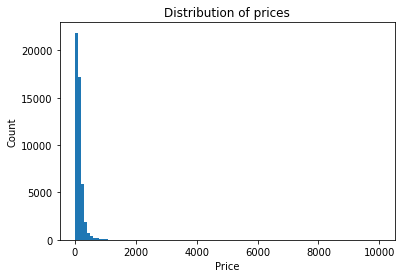

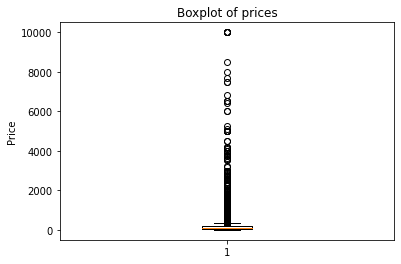

In [25]:
### Function to display distribution of prices

def visual_price(df) :   

    # create a histogram of the "price" variable
    plt.hist(df['price'], bins=100)
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.title('Distribution of prices')
    plt.show()

    # create a boxplot of the "price" variable
    plt.boxplot(df['price'])
    plt.ylabel('Price')
    plt.title('Boxplot of prices')
    plt.show()

####

visual_price(df_3)

In [22]:
### ISOLATION FOREST to detect outliers

# Select the column for outlier detection
column_name = 'price'

# Extract the column data as a numpy array
data = df_3[column_name].values.reshape(-1, 1)

# Create an instance of the IsolationForest class
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.03, random_state=42)

# Fit the model to the column data
model.fit(data)

IsolationForest(contamination=0.03, random_state=42)

In [23]:
### DEFINE OUTLIERS: points detected by Isolation Forest or with price < 10

# Predict the outlier status for each data point in the column
outliers = model.predict(data)

# Identify the outlier rows in the dataframe
outlier_rows = df_3[(outliers == -1) | (df_3['price'] < 10)]

# Print the proportion of outliers in dataset
print('Outlier rate in dataset:', round(len(outlier_rows['price'])/len(df)*100),'%')

### Characteristics of outliers
outlier_rows['price'].describe()

Outlier rate in dataset: 3 %


count     1448.000000
mean       944.014503
std       1040.425135
min          0.000000
25%        500.000000
50%        650.000000
75%        900.000000
max      10000.000000
Name: price, dtype: float64

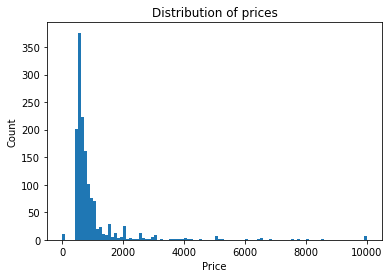

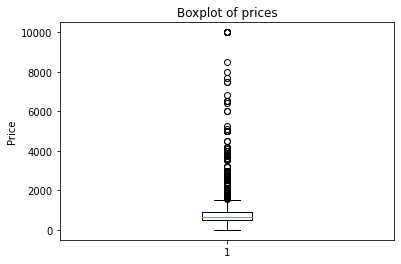

In [26]:
## Histogram of outliers
visual_price(outlier_rows)

In [27]:
### REMOVE OUTLIERS to get our final dataset
df_cleaned = df_3[(outliers == 1) & (df_3['price'] > 10)]

In [28]:
print('number of rows in cleaned dataset:',len(df_cleaned))

number of rows in cleaned dataset: 47430


In [29]:
df_cleaned.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_1,neighbourhood_2,neighbourhood_3
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,1,0,0,0,0.0,0.0,1.0
1,40.75362,-73.98377,225,1,45,0.38,2,355,1,0,0,0,0,1,0,0,0.0,0.0,1.0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,1,0,0,0,1,0,0,-1.0,0.0,0.0
3,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,1,0,0,0,1.0,0.0,0.0
4,40.79851,-73.94399,80,10,9,0.10,1,0,1,0,0,0,0,1,0,0,0.0,0.0,1.0


In [30]:
### Columns and their types of cleaned dataset
df_cleaned.dtypes

latitude                                        float64
longitude                                       float64
price                                             int64
minimum_nights                                    int64
number_of_reviews                                 int64
reviews_per_month                               float64
calculated_host_listings_count                    int64
availability_365                                  int64
room_type_Entire home/apt                         uint8
room_type_Private room                            uint8
room_type_Shared room                             uint8
neighbourhood_group_Bronx                         uint8
neighbourhood_group_Brooklyn                      uint8
neighbourhood_group_Manhattan                     uint8
neighbourhood_group_Queens                        uint8
neighbourhood_group_Staten Island                 uint8
neighbourhood_1                      Sparse[float64, 0]
neighbourhood_2                      Sparse[floa

In [31]:
## Check presence of null values in rows of clean dataset
df_cleaned.isnull().any()

latitude                             False
longitude                            False
price                                False
minimum_nights                       False
number_of_reviews                    False
reviews_per_month                    False
calculated_host_listings_count       False
availability_365                     False
room_type_Entire home/apt            False
room_type_Private room               False
room_type_Shared room                False
neighbourhood_group_Bronx            False
neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan        False
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
neighbourhood_1                      False
neighbourhood_2                      False
neighbourhood_3                      False
dtype: bool

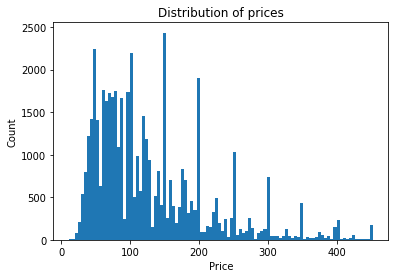

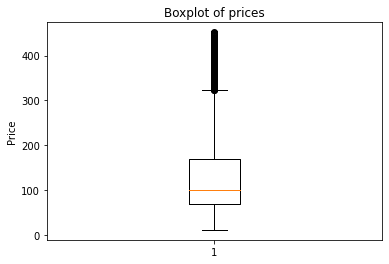

In [32]:
# Distribution price visualisation after pre-processing data
visual_price(df_cleaned)

### Defining the base ensemble models

#### Split data

In [36]:
X=df_cleaned.drop('price', axis=1)
y=df_cleaned['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Features importance function

In [39]:
def important_features(model, X):
  importances=model.feature_importances_
  df_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

  # Ordering by decreasing order
  df_importances = df_importances.sort_values('importance', ascending=False).reset_index(drop=True)

  # Barplot
  plt.figure(figsize=(10, 6))
  plt.bar(df_importances['feature'], df_importances['importance'])
  plt.xticks(rotation=90)
  plt.ylabel('Importance')
  plt.show()

  # Sélectionner les variables les plus importantes (par exemple, les 5 premières)
  top_features = df_importances['feature'][:5].tolist()
  print('Top features:', top_features)

#### Decision Tree

In [50]:
# Instancier le modèle Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42,max_depth= 8, min_samples_leaf= 14, min_samples_split=2)

# Entraîner le modèle sur les données d'entraînement
dt.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = dt.predict(X_test)

# RMSE and R^2 for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# RMSE
print("RMSE: ", rmse)

# Print the R^2 score
print("R^2: ", r2)

RMSE:  58.57811486318271
R^2:  0.4949865126621408


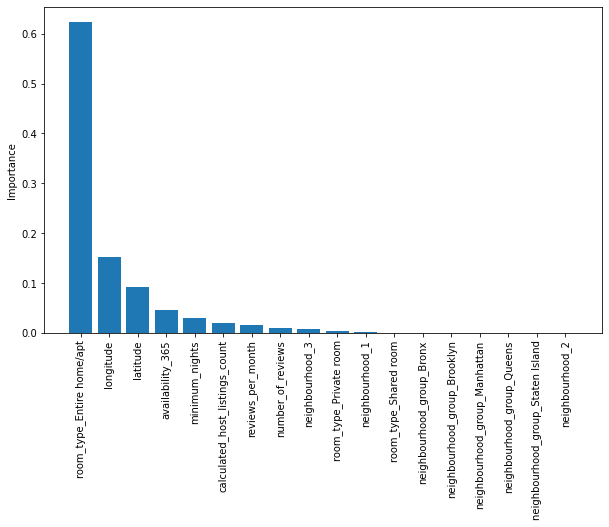

Top features: ['room_type_Entire home/apt', 'longitude', 'latitude', 'availability_365', 'minimum_nights']


In [40]:
# FEATURES IMPORTANCES
important_features(dt, X)

#### Bagging

##### Random Forest

In [51]:
# RANDOM FOREST with best model params
rf = RandomForestRegressor(n_estimators=400, max_depth = 50, min_samples_split = 4,min_samples_leaf =5,max_features='sqrt', bootstrap = True, random_state=42)
rf.fit(X_train, y_train)

## Predictions on test dataset
y_pred=rf.predict(X_test)

# RMSE and R^2 for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# RMSE
print("RMSE: ", rmse)

# Print the R^2 score
print("R^2: ", r2)

RMSE:  55.43413904195577
R^2:  0.5477414271130827


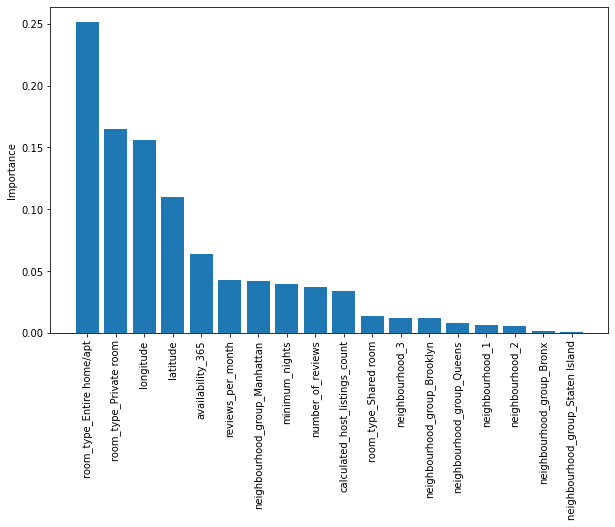

Top features: ['room_type_Entire home/apt', 'room_type_Private room', 'longitude', 'latitude', 'availability_365']


In [42]:
# Feature importance
important_features(rf, X)

It is interesting to observe that with random forest, there are more features with importance than for the decision tree, that focuses mainly on room type.

#### Boosting

##### Extreme Gradient Boosting (XGBoost)

In [43]:
xgboost = xgb.XGBRegressor(
                max_depth = 10,
                min_child_weight = 0,
                reg_alpha = 3,
                reg_lambda  = 1.5,
                subsample = 0.9,
                gamma = 0,
                max_delta_step = 0,
                max_leaves = 0,
                colsample_bytree = 0.55,
                learning_rate = 0.045,
                max_bin = 300,
                n_estimators = 140,
                scale_pos_weight = 0,
                random_state = 42)

xgboost.fit(X_train, y_train)

## Predictions on test dataset
y_pred=xgboost.predict(X_test)

# RMSE and R^2 for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# RMSE
print("RMSE: ", rmse)

# Print the R^2 score
print("R^2: ", r2)

RMSE:  55.11506183814025
R^2:  0.5529328161955109


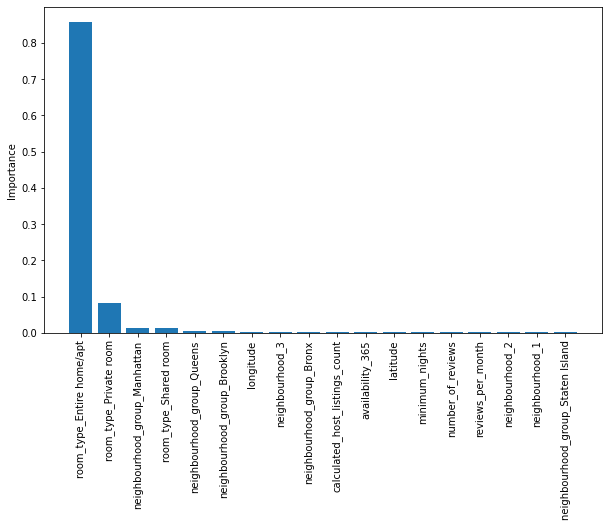

Top features: ['room_type_Entire home/apt', 'room_type_Private room', 'neighbourhood_group_Manhattan', 'room_type_Shared room', 'neighbourhood_group_Queens']


In [44]:
# Features importance
important_features(xgboost, X)

##### Adaboost

In [52]:
# Initialize the model
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth = 5, min_samples_split = 4, min_samples_leaf = 12),
                             n_estimators=50,
                             learning_rate=0.01,
                             loss = 'linear',
                             random_state=42)

# Fit the model to the training data
adaboost.fit(X_train, y_train)

# Evaluate the performance of the model on the testing data
y_pred = adaboost.predict(X_test)

# RMSE and R^2 for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# RMSE
print("RMSE: ", rmse)

# Print the R^2 score
print("R^2: ", r2)


RMSE:  59.788236127376656
R^2:  0.4739056030518799


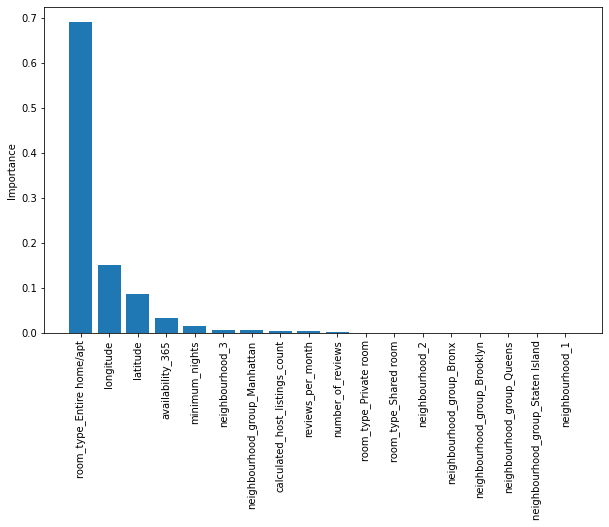

Top features: ['room_type_Entire home/apt', 'longitude', 'latitude', 'availability_365', 'minimum_nights']


In [46]:
# Features importance
important_features(adaboost, X)

### Building the stacked model

In [56]:
base_models = [
    ('Decision Tree', dt),

    ('Random Forest', rf),

    ('XGBoost', xgboost),
               
    ('AdaBoost', adaboost)
    ]

stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 5)

### Runing the base and stacked models

In [57]:
for name, model in base_models:
    start_time = time.time()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    end_time = time.time()
    
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, prediction, squared = False)
    
    print("-------{}-------".format(name))
    print("R^2 Score: {}".format(r2))
    print("RMSE: {}".format(rmse))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")

start_time = time.time()
stacked.fit(X_train, y_train)    
stacked_prediction = stacked.predict(X_test)
end_time = time.time()
stacked_r2 = stacked.score(X_test, y_test)
stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)

print("-------Stacked Ensemble-------")
print("R^2 Score: {}".format(stacked_r2))
print("RMSE: {}".format(stacked_rmse))
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

-------Decision Tree-------
R^2 Score: 0.4949865126621408
RMSE: 58.57811486318271
Computation Time: 0.17444348335266113
----------------------------------

-------Random Forest-------
R^2 Score: 0.5477414271130827
RMSE: 55.43413904195577
Computation Time: 22.681992053985596
----------------------------------

-------XGBoost-------
R^2 Score: 0.5529328161955109
RMSE: 55.11506183814025
Computation Time: 7.9970762729644775
----------------------------------

-------AdaBoost-------
R^2 Score: 0.4739056030518799
RMSE: 59.788236127376656
Computation Time: 6.506806135177612
----------------------------------

-------Stacked Ensemble-------
R^2 Score: 0.5562742137759649
RMSE: 54.908709481961395
Computation Time: 187.16257858276367
----------------------------------


### Conclusion

Out of the tested model, XGBoost is the one that works best on our clean Airbnb data, closely follwed by Random Forest. It is not surprising that these two models show the best performance. Indeed, they respectively use boosting and bagging techniques to improve the prediction compared to a single decision tree. They reduce the variance and the bias. Adaboost shows the worst performance, which is not very surprising given that this model does not handle outliers well. In fact, although we have put some effort into eliminating unusual observations, the data remains unbalanced. Finally, stacking the models gives the best performance, but it does not represent an impressive improvement (indeed, we are able to reach 54.4 of RMSE, vs 55.1 for XGBoost). It is also important to notice that additionnally, the computation time for the stacked ensembles model is much longer than for the other models.